In [37]:
!pip install icecream
!pip install segmentation_models_pytorch

In [38]:
import os
from osgeo import gdal
import numpy as np
from icecream import ic # icecream is a debugging tool. See https://github.com/gruns/icecream
import matplotlib.pyplot as plt

## Download data

Dataset is in https://drive.google.com/file/d/1AUkcQzHuB6EMa0OBMAahYRzxl_Vtik0-/view?usp=drive_link

In [39]:
!gdown --i 1AUkcQzHuB6EMa0OBMAahYRzxl_Vtik0-


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AUkcQzHuB6EMa0OBMAahYRzxl_Vtik0-
To: /content/images.rar
100% 24.9M/24.9M [00:00<00:00, 140MB/s]


In [40]:
!unrar -y x "/content/images.rar"
os.remove("/content/images.rar")



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/images.rar

Extracting  images/Images_Test/Image_Test.tif                             16% 33% 50% 58%  OK 
Extracting  images/Images_Test/Reference_Test.tif                         60%  OK 
Extracting  images/Images_Train/Image_Train.tif                           76% 93% 99%  OK 
Extracting  images/Images_Train/Reference_Train.tif                       99%  OK 
All OK


In [41]:
train_input_path = "/content/images/Images_Train/Image_Train.tif"
train_reference_path = "/content/images/Images_Train/Reference_Train.tif"

test_input_path = "/content/images/Images_Test/Image_Test.tif"
test_reference_path = "/content/images/Images_Test/Reference_Test.tif"


In [42]:
def read_tiff(tiff_file):
    data = gdal.Open(tiff_file).ReadAsArray()
    data = np.transpose(data, (1, 2, 0))
    return data

In [43]:
im_train = read_tiff(train_input_path)
reference_train_rgb = read_tiff(train_reference_path)

im_test = read_tiff(test_input_path)
reference_test_rgb = read_tiff(test_reference_path)

ic(im_train.shape, reference_train_rgb.shape)
ic(im_test.shape, reference_test_rgb.shape)


ic| im_train.shape: (2565, 1919, 3)
    reference_train_rgb.shape: (2565, 1919, 3)
ic| im_test.shape: (2558, 2818, 3)
    reference_test_rgb.shape: (2558, 2818, 3)


((2558, 2818, 3), (2558, 2818, 3))

## Classes are:

0.   Impervious surfaces (RGB: 255, 255, 255)
1.   Building (RGB: 0, 0, 255)
2.   Low vegetation (RGB: 0, 255, 255)
3.   Tree (RGB: 0, 255, 0)
4.   Car (RGB: 255, 255, 0)







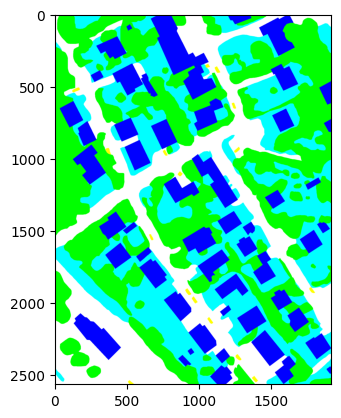

In [44]:
plt.imshow(reference_train_rgb)

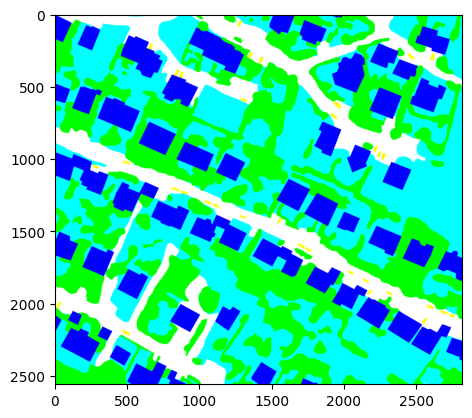

In [45]:
plt.imshow(reference_test_rgb)

## Utilities to convert reference from RGB to grayscale and from grayscale to RGB

In [46]:

def label_rgb_to_grayscale(msk):

    msk = msk.astype(np.int64)
    new = np.zeros((msk.shape[0], msk.shape[1]), dtype=np.int64)

    msk = msk // 255
    msk = msk * (1, 7, 49)
    msk = msk.sum(axis=2)

    new[msk == 1 + 7 + 49] = 0 # Street.
    new[msk ==         49] = 1 # Building.
    new[msk ==     7 + 49] = 2 # Grass.
    new[msk ==     7     ] = 3 # Tree.
    new[msk == 1 + 7     ] = 4 # Car.
    new[msk == 1         ] = 5 # Surfaces.
    new[msk == 0         ] = 6 # Boundaries.

    return new

colormap = {0: [255, 255, 255],
            1: [0, 0, 255],
            2: [0, 255, 255],
            3: [0, 255, 0],
            4: [255, 255, 0]}

def label_grayscale_to_rgb(label):

    msk = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)

    for c in colormap.keys():
      msk[..., 0][label == c] = colormap[c][0]
      msk[..., 1][label == c] = colormap[c][1]
      msk[..., 2][label == c] = colormap[c][2]

    return msk

In [47]:
reference_train = label_rgb_to_grayscale(reference_train_rgb)
reference_test = label_rgb_to_grayscale(reference_test_rgb)


In [48]:
ic(reference_train.shape)

ic| reference_train.shape: (2565, 1919)


(2565, 1919)

## Visualize dataset

ic| np.unique(reference_train, return_counts=True): (array([0, 1, 2, 3, 4]), array([1132698,  867583, 1255273, 1653521,   13160]))
ic| np.unique(reference_test, return_counts=True): (array([0, 1, 2, 3, 4]), array([1185224, 1302768, 2549104, 2144306,   27042]))


Text(0.5, 1.0, 'reference test')

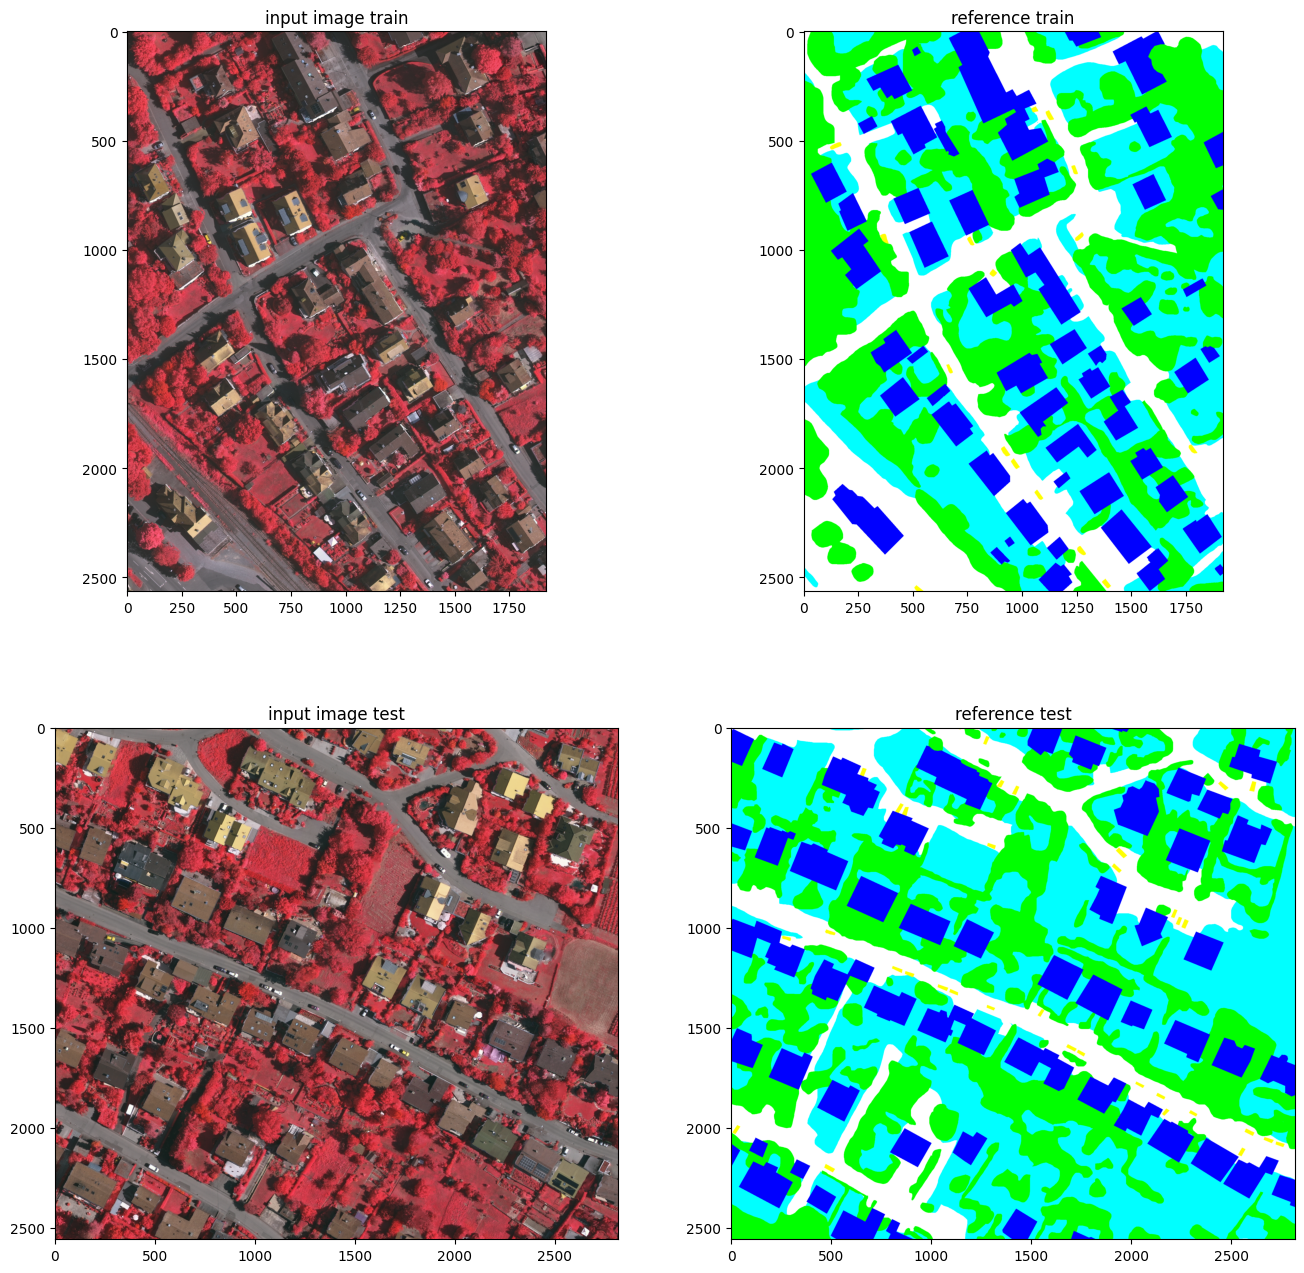

In [49]:
ic(np.unique(reference_train, return_counts=True))
ic(np.unique(reference_test, return_counts=True))

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.imshow(im_train/255)
plt.title('input image train')
plt.subplot(222)
plt.imshow(reference_train_rgb)
plt.title('reference train')

plt.subplot(223)
plt.imshow(im_test/255)
plt.title('input image test')

plt.subplot(224)
plt.imshow(reference_test_rgb)
plt.title('reference test')

## Extract image patches

We use `view_as_windows` from `skimage`. See the documentation https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.view_as_windows

In [50]:
from skimage.util import view_as_windows
channel_n = 3
patch_len = 128

train_step = patch_len//2

ic(im_train.shape)

im_train_patch = view_as_windows(im_train, (patch_len, patch_len, channel_n), step=train_step)
reference_train_patch = view_as_windows(reference_train, (patch_len, patch_len), step=train_step)

#del im_train, reference_train

im_train_patch = im_train_patch.reshape(-1, patch_len, patch_len, channel_n)
reference_train_patch = reference_train_patch.reshape(-1, patch_len, patch_len)

ic(im_train_patch.shape)
ic(reference_train_patch.shape)

print("Number of training patches:", im_train_patch.shape[0])

ic| im_train.shape: (2565, 1919, 3)
ic| im_train_patch.shape: (1092, 128, 128, 3)
ic| reference_train_patch.shape: (1092, 128, 128)


Number of training patches: 1092


## Convert labels to one-hot

In [51]:
class_n = len(np.unique(reference_train))
ic(np.unique(reference_test))
def to_one_hot(reference, class_n):
    b = np.zeros((reference.size, class_n))
    b[np.arange(reference.size), reference] = 1
    return b

def patches_to_one_hot(reference_patch, class_n):
    shape = reference_patch.shape
    reference_patch = to_one_hot(reference_patch.flatten(), class_n)
    reference_patch = reference_patch.reshape((*shape, class_n))
    return reference_patch

reference_train_patch = patches_to_one_hot(reference_train_patch, class_n)
ic(reference_train_patch.shape)
ic(class_n)


ic| np.unique(reference_test): array([0, 1, 2, 3, 4])
ic| reference_train_patch.shape: (1092, 128, 128, 5)
ic| class_n: 5


5

## Split training patches into 80% for training and 20% for validation

In [52]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch

# Assuming your train input and reference are already tensors
train_input = im_train_patch
train_reference = reference_train_patch

# Split data into training and validation sets (80%/20%)
train_input, val_input, train_reference, val_reference = train_test_split(train_input, train_reference, test_size=0.2, random_state=42)


## Define the Pytorch DataLoader for training and validation

Hint: Remember to normalize the input images. Each encoder has its own normalization parameters, obtained as:

`params = smp.encoders.get_preprocessing_params(encoder_name)`

Where mean and std parameters will be `params['mean']` and `params['std']`, respectively.

See the class hands-on for more details.

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
!cp "/content/drive/My Drive/densenet161-347e6b360.pth" "/root/.cache/torch/hub/checkpoints/densenet161-347e6b360.pth"


In [55]:
from torchvision import transforms
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

encoder_name = 'densenet161'
params = smp.encoders.get_preprocessing_params(encoder_name)
mean = params['mean'] # [0.4, 0.4, 0.4]
std = params['std'] # [0.1, 0.1, 0.1]

# Define separate datasets for training and validation
class CustomDataset(Dataset):
    def __init__(self, input, reference, transform=None, transform_reference=None):
        self.input = input
        self.reference = reference
        self.transform = transform
        self.transform_reference = transform_reference
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        image = self.input[idx]
        label = self.reference[idx]
        # Apply the transform to the image
        if self.transform is not None:
            image = self.transform(image)
        if self.transform_reference is not None:
            label = self.transform_reference(label)
        return image, label


# Define a transform that first converts the image to a tensor and then normalizes it
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize
])

transform_reference = transforms.ToTensor()

# Create training and validation dataset instances
train_dataset = CustomDataset(train_input, train_reference, transform=transform, transform_reference=transform_reference)
val_dataset = CustomDataset(val_input, val_reference, transform=transform, transform_reference=transform_reference)


# Create separate DataLoaders for training and validation
train_batch_size = 64 # Adjust batch_size as needed
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Don't shuffle validation data

## Define your model using SMP

In [56]:

# You: Define model architecture
import torch
import segmentation_models_pytorch as smp

# Defina o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defina o número de classes
numero_de_classes = 5

# Defina o modelo
model = smp.PSPNet(
    encoder_name="densenet161",
    encoder_weights="imagenet",
    classes=numero_de_classes
).to(device)

# Calcula o número de parâmetros
total_params = sum(p.numel() for p in model.parameters())
print(f"Total de parâmetros (M): {total_params / 1e6} M")

Total de parâmetros (M): 27.873669 M


## Definition of early stopping.

Use as in the next example https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

In [57]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define your training loop.

1. You can reuse code from the class hands-on https://colab.research.google.com/drive/1XVEgeZotsafKc5cQJI8I4_sPygcsd_q4?usp=sharing

2. The next link contains another training example using Pytorch. Use early stopping on the validation set as in https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb


Epoch 1/50 	 Training Loss: 0.7719 	 Validation Loss: 0.8140
Validation loss decreased (inf --> 0.814041).  Saving model ...
Epoch 2/50 	 Training Loss: 0.3739 	 Validation Loss: 0.5335
Validation loss decreased (0.814041 --> 0.533502).  Saving model ...
Epoch 3/50 	 Training Loss: 0.2729 	 Validation Loss: 0.3161
Validation loss decreased (0.533502 --> 0.316146).  Saving model ...
Epoch 4/50 	 Training Loss: 0.2098 	 Validation Loss: 0.2577
Validation loss decreased (0.316146 --> 0.257667).  Saving model ...
Epoch 5/50 	 Training Loss: 0.1859 	 Validation Loss: 0.2134
Validation loss decreased (0.257667 --> 0.213435).  Saving model ...
Epoch 6/50 	 Training Loss: 0.1520 	 Validation Loss: 0.1952
Validation loss decreased (0.213435 --> 0.195218).  Saving model ...
Epoch 7/50 	 Training Loss: 0.1457 	 Validation Loss: 0.2047
EarlyStopping counter: 1 out of 10
Epoch 8/50 	 Training Loss: 0.1421 	 Validation Loss: 0.1720
Validation loss decreased (0.195218 --> 0.171950).  Saving model ...

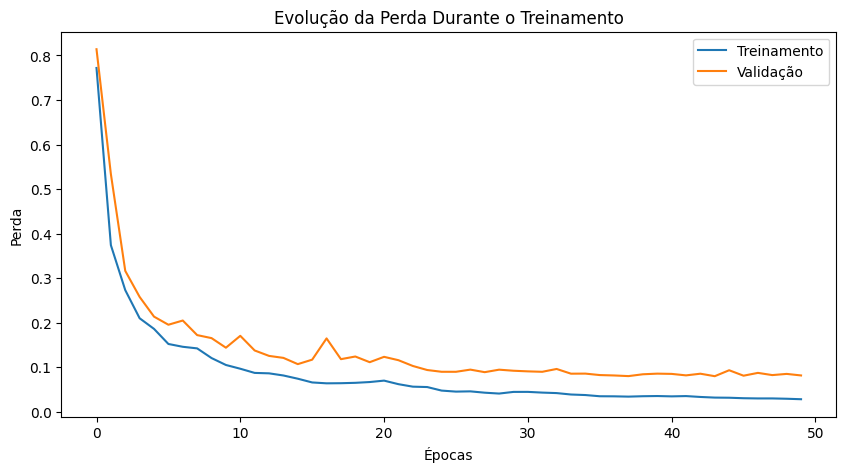

Tempo de treinamento (m): 5.77 minutos
Treinamento concluído.


In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

# Supondo que 'EarlyStopping' já esteja definido em outro lugar no seu código

# Define o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Número de classes
numero_de_classes = 5

# Define o modelo, critério (função de perda) e otimizador
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Parâmetros de treinamento
num_epochs = 50
patience = 10  # Para early stopping

# Listas para armazenar as perdas por época
train_losses = []
val_losses = []

# Inicialização do EarlyStopping
early_stopping = EarlyStopping(patience=patience, verbose=True, path='checkpoint.pt')

# Começa a contar o tempo
start_time = time.time()

# Loop de treinamento com Early Stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zera os gradientes
        optimizer.zero_grad()

        # Executa o modelo e calcula a perda
        outputs = model(inputs)
        labels = torch.argmax(labels, dim=1)  # Converte de one-hot para índices de classe
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # Calcula a perda média de treinamento
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validação
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = torch.argmax(labels, dim=1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    # Calcula a perda média de validação
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs} \t Training Loss: {train_loss:.4f} \t Validation Loss: {val_loss:.4f}')

    # Checa se deve realizar a parada antecipada
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Carrega os melhores pesos do modelo
model.load_state_dict(torch.load('checkpoint.pt'))

# Calcula o tempo de treinamento
end_time = time.time()
training_time_seconds = end_time - start_time
training_time_minutes = training_time_seconds / 60

# Plotando as curvas de perda
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Treinamento')
plt.plot(val_losses, label='Validação')
plt.title('Evolução da Perda Durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

print(f"Tempo de treinamento (m): {training_time_minutes:.2f} minutos")
print("Treinamento concluído.")


## Evaluate the test set

The function `patch_inference()` performs inference on an image using a patch-based approach. If you have any problems with this function, please contact me at cmjorgeandres@gmail.com.

In [59]:
import torch
import numpy as np
import torch.nn.functional as F

def patch_inference(image, model, patch_len, overlap_percentage, num_classes):
    device = next(model.parameters()).device
    model.to(device)
    model.eval()

    # Assegura que a imagem esteja no formato correto [C, H, W] e no dispositivo adequado
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image).float()
    if image.dim() == 3:  # [H, W, C]
        image = image.permute(2, 0, 1)  # Converte para [C, H, W]
    image = image.unsqueeze(0).to(device)  # Adiciona a dimensão do batch [B, C, H, W]

    _, C, H, W = image.shape

    # Calcula o padding necessário
    overlap = int(patch_len * overlap_percentage)
    stride = patch_len - overlap
    padding_h = (stride - H % stride) % stride
    padding_w = (stride - W % stride) % stride

    # Aplica padding apenas nas dimensões de altura e largura
    pad_tuple = (padding_w // 2, padding_w - padding_w // 2, padding_h // 2, padding_h - padding_h // 2)
    image_padded = F.pad(image, pad=(pad_tuple[0], pad_tuple[1], pad_tuple[2], pad_tuple[3]), mode='reflect')
    _, _, padded_h, padded_w = image_padded.shape

    # Inicializa o tensor de saída com o número correto de classes para a segmentação semântica
    output_mosaic = torch.zeros((1, num_classes, padded_h, padded_w), device=device)

    # Calcula o número de patches em cada dimensão
    n_patches_x = (padded_w - overlap) // stride
    n_patches_y = (padded_h - overlap) // stride

    # Itera sobre os patches da imagem
    for i in range(n_patches_y):
        for j in range(n_patches_x):
            start_x = j * stride
            end_x = start_x + patch_len
            start_y = i * stride
            end_y = start_y + patch_len

            # Extrai o patch
            patch = image_padded[:, :, start_y:end_y, start_x:end_x]

            # Realiza a inferência no patch
            with torch.no_grad():
                patch_output = model(patch)

            # Assume que patch_output seja [B, num_classes, patch_height, patch_width]
            # Aqui você pode precisar ajustar a lógica dependendo do formato exato da saída do seu modelo
            output_mosaic[:, :, start_y:end_y, start_x:end_x] = patch_output

    # Ajusta as dimensões do tensor de saída para remover o padding e prepara para visualização
    output_image = output_mosaic[:, :, padding_h // 2: H + padding_h // 2, padding_w // 2: W + padding_w // 2]
    return output_image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Formato [H, W, C] para visualização

# Exemplo de chamada à função:
# result = patch_inference(im_test_norm, model, patch_len=128, overlap_percentage=0.5, num_classes=NUM_CLASSES)
# plt.imshow(result)


`overlap_percentage` indicates the amount of overlap between inference sub-images. A larger overlap may yield a better result, but may result in higher processing times.

Hint: Remember to normalize the input images before running inference. Each encoder has its own normalization parameters, obtained as:

`params = smp.encoders.get_preprocessing_params(encoder_name)`

Where mean and std parameters will be `params['mean']` and `params['std']`, respectively.

See the class hands-on for more details.

In [60]:
import torch

def normalize_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img).float()  # Converte de NumPy para Tensor PyTorch
    img = img / 255.0  # Normaliza os pixels para o intervalo [0, 1]

    for channel in range(3):
        img[..., channel] -= mean[channel]
        img[..., channel] /= std[channel]

    return img


In [61]:

overlap_percentage = 0.5
im_test_norm = normalize_image(im_test, mean=mean, std=std) # You: Normalize input image

result = patch_inference(im_test_norm, model, patch_len=128,
                                    overlap_percentage=overlap_percentage,num_classes=5)
result = result[:im_test_norm.shape[0], :im_test_norm.shape[1]]

In [62]:
result.shape

(2558, 2818, 5)

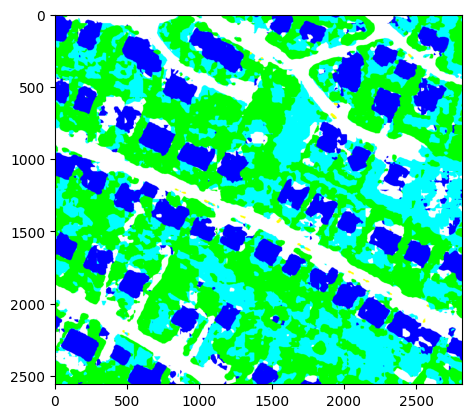

In [63]:
# Supondo que 'result' tenha a forma (H, W, C), onde C é o número de classes
# Converter as probabilidades em índices de classe máxima por pixel
result_max = np.argmax(result, axis=-1)

# Convertendo índices de classe para uma imagem RGB usando o colormap fornecido
result_rgb = np.zeros((result_max.shape[0], result_max.shape[1], 3), dtype=np.uint8)
for class_idx, color in colormap.items():
    result_rgb[result_max == class_idx] = color

plt.imshow(result_rgb)
plt.show()

## Calculate test metrics
Metrics must be calculated on the reconstructed (large) image

Hint: Use sklearn library

* Accuracy: sklearn.metrics.accuracy_score https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
* F1-score: sklearn.metrics.f1_score: Use average=None for individual per-class values. Use average='macro' for class average F1-score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
* mIoU: sklearn.metrics.jaccard_score: Use average='macro' for mIoU (Mean intersection over union) https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

In [64]:
# Exemplo de colormap para conversão, ajuste conforme o seu caso
colormap = {
    0: [255, 255, 255],  # Classe 0
    1: [0, 0, 255],      # Classe 1
    # Adicione mais classes conforme necessário
}
# Inverte o colormap para mapeamento de cores para rótulos
inverse_colormap = {tuple(v): k for k, v in colormap.items()}

# Inicializa a matriz de rótulos baseada no tamanho de result_rgb
result_labels = np.zeros((result_rgb.shape[0], result_rgb.shape[1]), dtype=int)

# Converte cada pixel de RGB para o rótulo de classe correspondente
for key, value in inverse_colormap.items():
    result_labels[(result_rgb == key).all(axis=-1)] = value


In [65]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Calcula a acurácia
accuracy = accuracy_score(reference_test.flatten(), result_max.flatten())

# Calcula o F1-score para cada classe e a média macro
f1_scores_per_class = f1_score(reference_test.flatten(), result_max.flatten(), average=None)
f1_score_macro = f1_score(reference_test.flatten(), result_max.flatten(), average='macro')

# Calcula o Mean Intersection over Union (mIoU)
miou = jaccard_score(reference_test.flatten(), result_max.flatten(), average='macro', zero_division=0)

print(f"Acurácia: {accuracy}")
print(f"F1-score por classe: {f1_scores_per_class}")
print(f"F1-score médio (macro): {f1_score_macro}")
print(f"mIoU: {miou}")


Acurácia: 0.7643917328066917
F1-score por classe: [0.77947201 0.88932087 0.66786775 0.77698088 0.41335811]
F1-score médio (macro): 0.7053999260955608
mIoU: 0.567301784638423


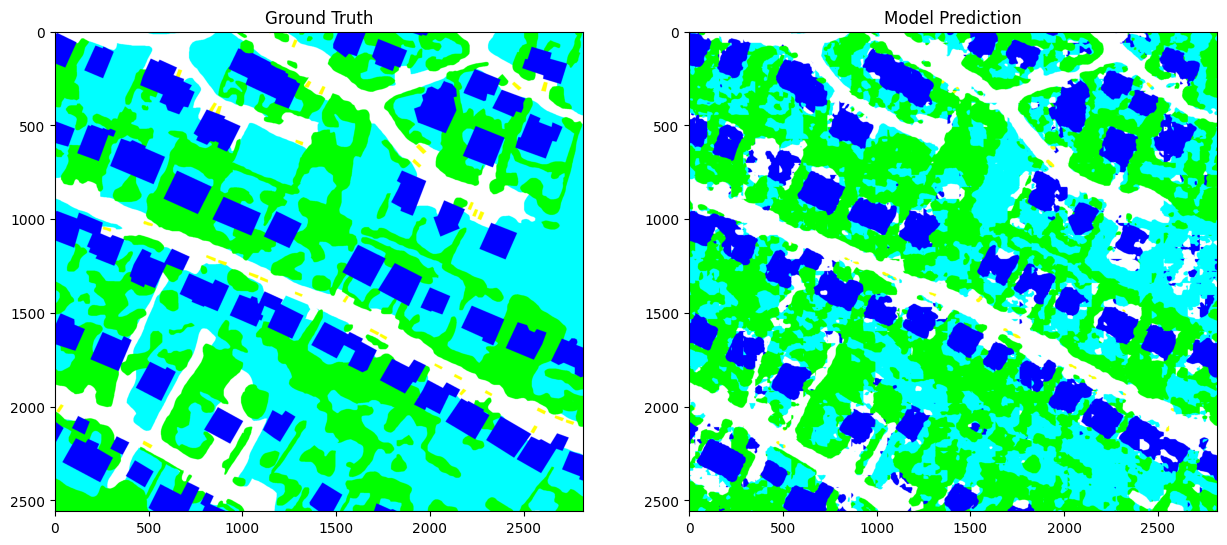

In [66]:
import matplotlib.pyplot as plt

# Suponha que 'reference_rgb' seja a imagem de anotação verdadeira correspondente a 'result_rgb'
# e que ambas estejam na mesma codificação de cores RGB.

# Carregue a imagem de anotação verdadeira, se já não estiver carregada
# reference_rgb = ...

# Assegure-se de que ambas as imagens tenham o mesmo tamanho/dimensões
assert result_rgb.shape == reference_test_rgb.shape, "As imagens devem ter o mesmo tamanho"

# Configure o tamanho da figura para a visualização
plt.figure(figsize=(15, 10))

# Exiba a imagem de anotação verdadeira
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
plt.imshow(reference_test_rgb)
plt.title('Ground Truth')

# Exiba a imagem de previsão do modelo
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
plt.imshow(result_rgb)
plt.title('Model Prediction')

# Mostre as imagens lado a lado
plt.show()
